# Install Packages

In [ ]:
!pip install pipreqs
#!pip install pycaret[full]
#!pip install explainerdashboard
#!pip install --upgrade fairlearn==0.7.0 raiwidgets

# Import Modules

In [ ]:
import os
from pathlib import Path
from google.colab import drive
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Set Hyperparameters

In [ ]:
# set seed for reproducibility
seed = 123

# define features and target
features = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']
target = 'Diabetic'

# Mount Google Drive

In [ ]:
# mount data
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Set Path Variables

In [ ]:
# set paths
ROOTDIR = '/content/gdrive/MyDrive/Healthrisk_Modeling'
DATAPATH = "/content/gdrive/MyDrive/Healthrisk_Modeling/data"
MODELPATH = "/content/gdrive/MyDrive/Healthrisk_Modeling/model"

Path(DATAPATH).mkdir(parents=True, exist_ok=True)
Path(MODELPATH).mkdir(parents=True, exist_ok=True)

os.chdir(ROOTDIR)
print('The working directory is: ', os.getcwd())

The working directory is:  /content/gdrive/.shortcut-targets-by-id/1YbeiU8614CIYyOtzeKzF0fvIZaLY92Xo/Healthrisk_Modeling


# Helper Functions

In [ ]:
def generate_random_indices(n:int, range_min:int, range_max:int, seed:int)->list:
  """ generate n random indices in given range for given seed. """
  random.seed(seed)
  random_indices = random.sample(range(range_min, range_max), n)
  return random_indices

def add_NAs_to_features(data:pd.DataFrame, feature_list:list, number_na:int, seed:int):
  """ Add number_na NAs in given features i.e. feature_list to given dataframe i.e. data. provide seed for reproducibility. """
  counter = 0
  for column in feature_list:
    counter += 1
    print('add NAs to feature ', column)
    # lets generate NAs in number_na rows
    random_indices = generate_random_indices(n=number_na, 
                                            range_min=0, range_max=data.shape[0], 
                                            seed=seed+counter)
    # impute NAs at random indices
    data.loc[random_indices, column] = np.nan
  return data

def visualize_numfeatures_stratifiedbytarget(data:pd.DataFrame, numeric_features:list, target:str, positive_class:str, negative_class:str):
  """ Plot histograms and boxplots for numeric features given a binary target """
  for col in numeric_features:
    try:
      fig, ax = plt.subplots(1,2, figsize=(12,5))
      
      sns.histplot(data=data, 
                  x=col, 
                  hue=target, 
                  stat='percent', 
                  kde=True,
                  element='step',
                  ax=ax[0])
      ax[0].set_title(col)
      ax[0].legend([positive_class, negative_class])

      sns.boxplot(data=data, 
                  y=col, 
                  x=target,
                  ax=ax[1])
      ax[1].set_title(col)
      ax[1].set_xticklabels([negative_class, positive_class])

      plt.show()
    except:
      print('Singular matrix error due to constant feature value')

# Data Import

In [ ]:
# load the diabetes dataset containing the artificially generated NAs
print("Loading Data...")
df = pd.read_csv(Path(DATAPATH) / 'diabetes_nas.csv')
df.head()

Loading Data...


,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0.0,171.0,80.0,34.0,23.0,43.509726,1.213191,21.0,0
1,1147438,8.0,NaN,93.0,47.0,36.0,21.240576,0.158365,23.0,0
2,1640031,7.0,115.0,47.0,52.0,35.0,41.511523,0.079019,23.0,0
3,1883350,9.0,103.0,78.0,25.0,304.0,29.582192,1.282870,43.0,1
4,1424119,1.0,85.0,59.0,27.0,NaN,42.604536,0.549542,22.0,0


# Train Test Split

In [ ]:
# get features and target
X = df[features]
y = df[target]

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7000, 8), (7000,), (3000, 8), (3000,))

# Make Pipeline

In [ ]:
# choose classifier
classifier = GradientBoostingClassifier(random_state=seed)
#classifier = RandomForestClassifier(random_state=seed)
#classifier = LogisticRegression(random_state=seed)

In [ ]:
# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_features = [0,1,2,3,4,5,6] # note that numbers are required here, not names!

## Define preprocessing for categorical features (e.g. encode the Age column)
categorical_features = [7]

In [ ]:
# setup the pipeline elements
numeric_transformer = Pipeline(steps=[
                                      ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                                      ('scaler', MinMaxScaler())
                                     ]
                               )

categorical_transformer = Pipeline(steps=[('onehotencode', OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
                                               ('num', numeric_transformer, numeric_features), 
                                               ('cat', categorical_transformer, categorical_features)
                                              ]
                                 )

In [ ]:
# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[
                           ('preprocessor', preprocessor),
                           ('gbc', classifier)
                          ]
                    )

In [ ]:
# fit the pipeline 
model = pipeline.fit(X_train, y_train)
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7])])),
                ('gbc', GradientBoostingClassifier(random_state=123))])


Confusion Matrix:
 [[1897   93]
 [ 125  885]] 

Accuracy: 0.9273333333333333
Overall Precision: 0.9049079754601227
Overall Recall: 0.8762376237623762
AUC: 0.9806895865465943


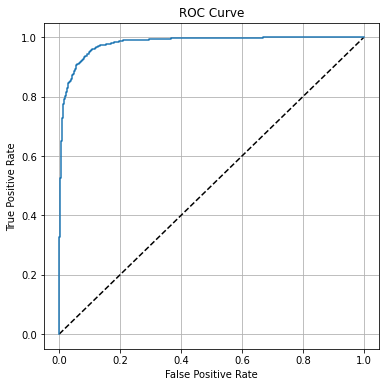

In [ ]:
# Get predictions from test data
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid('on')
plt.show()

In [ ]:
# Save the model as a pickle file
filename = '/diabetes_model.pkl'
joblib.dump(model, MODELPATH + filename)

['/content/gdrive/MyDrive/Healthrisk_Modeling/model/diabetes_model.pkl']

# Model Inference

Model looks good, let´s do inference

In [1]:
# Load the model from the file
model_loaded = joblib.load(MODELPATH + filename)
model_loaded

NameError: name 'joblib' is not defined

In [ ]:
# predict on a new sample
# The model accepts an array of feature arrays (so you can predict the classes of multiple patients in a single call)
# We'll create an array with a single array of features, representing one patient
X_new = np.array([[2,180,74,24,21,23,1.4,22]])
print ('New sample: {}'.format(list(X_new[0])))

# Get a prediction
pred = model_loaded.predict(X_new)

New sample: [2.0, 180.0, 74.0, 24.0, 21.0, 23.0, 1.4, 22.0]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
# The model returns an array of predictions - one for each set of features submitted
# In our case, we only submitted one patient, so our prediction is the first one in the resulting array.
print('Predicted class is {}'.format(pred[0]))

Predicted class is 1
